In [1]:
# PyTorch Library
import torch 
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import datasets 
import torchvision.models as models
from torch.optim import lr_scheduler

# PyTorch Neural Network Library
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as T
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np

# Allows us to access the filesystem
import os 
import glob
# Import PIL
from PIL import Image

import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Constant Parameters

In [3]:
# define paths
TRAIN_PATH = "/content/drive/MyDrive/CIN/Deep_Learning/OriginalData/train"
TEST_PATH = "/content/drive/MyDrive/CIN/Deep_Learning/OriginalData/test"

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
EPOCHS = 30

## Transformation for the images

In [6]:
# photos are taken with normal angle, no augmentation needed
train_transform = T.Compose([
    T.RandomResizedCrop(240),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(45),
    T.Resize(224),
    T.ToTensor(),
])

test_transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
])

## Load all data from the data directory

In [7]:
# create datasets
train_data = datasets.ImageFolder(TRAIN_PATH, transform=train_transform)
test_data = datasets.ImageFolder(TEST_PATH, transform=test_transform)

In [8]:
# create data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

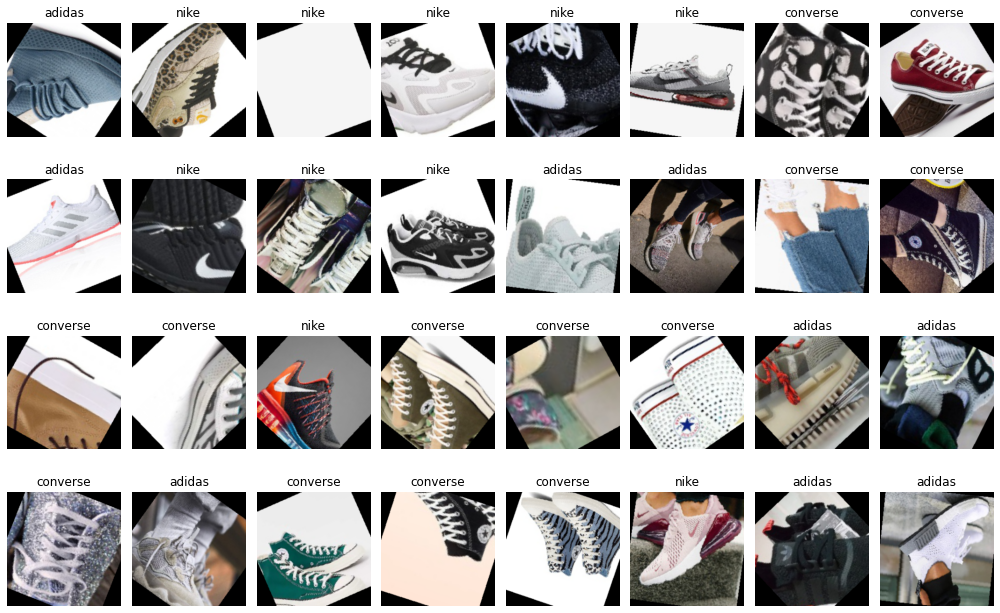

In [9]:
batch = next(iter(train_loader))

rows = 4
columns = int(BATCH_SIZE / rows)
class_dict = {0:'adidas', 1:'converse', 2:'nike'}

plt.figure(figsize = (14, 9))

for pos in range(BATCH_SIZE):
    plt.subplot(rows, columns, pos+1)
    plt.imshow(batch[0][pos].permute(1,2,0))
    plt.title(class_dict[batch[1][pos].item()])
    plt.axis('off')
plt.tight_layout()

## Define VGG16 model

In [10]:
VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

In [11]:
# Base class for all neural network modules.
# Your models should also subclass this class.
class VGG(nn.Module):
    def __init__(self, in_channels=3):
        super(VGG, self).__init__()  # initialize superclass
        self.in_channels = in_channels
        self.conv_layers = self.create_layers(VGG16)

        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1000),
        )

    # Define how the data flows through your model
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def create_layers(self, architecture):
        layers = []
        in_channel = self.in_channels

        for x in architecture:

            if isinstance(x, int):
                out_channel = x
                new_layer = [
                    nn.Conv2d(
                        in_channels=in_channel,
                        out_channels=out_channel,
                        kernel_size=3,
                        padding=1,
                        stride=1,
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]

                layers += new_layer
                in_channel = out_channel

            else:
                new_layer = [nn.MaxPool2d(kernel_size=2, stride=2)]
                layers += new_layer

        return nn.Sequential(*layers)
    

## Model configuration (loss function and optimizer)

In [28]:
# model configurations
model = VGG()
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = criterion.to(DEVICE)

## Model Training Function

In [29]:
def train_loop(dataloader, model, optimizer, criterion):
    for batch, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Zero your gradients for every batch!  
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        if (batch%5 == 0):
            print(f'Training loss: {loss: 7f} [{batch * 32} / {len(dataloader.dataset)}]')

In [30]:
def test_loop(dataloader, model, criterion):
    model.eval()
    test_loss = 0
    batches = len(dataloader)
    accuracy = 0
    
    for images, labels in dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(images)
            test_loss += criterion(outputs, labels)
            accuracy += (outputs.argmax(dim = 1) == labels).type(torch.float).sum().item()
    
    accuracy = accuracy / len(dataloader.dataset)
  
    print(f'Average Test Loss: {test_loss / batches: 7f} Accuracy: {accuracy*100: .2f}%\n')

## Model Training

In [31]:
for epoch in range(EPOCHS):
    print(f'-------------epoch-{epoch+1}--------------')
    train_loop(train_loader, model, optimizer, criterion)
    test_loop(test_loader, model, criterion)

-------------epoch-1--------------
Training loss:  6.957628 [0 / 711]
Training loss:  9.511519 [160 / 711]
Training loss:  4.428974 [320 / 711]
Training loss:  1.675493 [480 / 711]
Training loss:  1.859141 [640 / 711]
Average Test Loss:  7.921755 Accuracy:  32.46%

-------------epoch-2--------------
Training loss:  8.228793 [0 / 711]
Training loss:  2.481007 [160 / 711]
Training loss:  1.155492 [320 / 711]
Training loss:  1.053330 [480 / 711]
Training loss:  1.114062 [640 / 711]
Average Test Loss:  1.107652 Accuracy:  33.33%

-------------epoch-3--------------
Training loss:  1.178210 [0 / 711]
Training loss:  1.119896 [160 / 711]
Training loss:  1.104640 [320 / 711]
Training loss:  1.107770 [480 / 711]
Training loss:  1.168207 [640 / 711]
Average Test Loss:  1.123348 Accuracy:  33.33%

-------------epoch-4--------------
Training loss:  1.120181 [0 / 711]
Training loss:  1.168233 [160 / 711]
Training loss:  1.132018 [320 / 711]
Training loss:  1.108954 [480 / 711]
Training loss:  1.095

## Transfer Learning using VGG16

In [24]:
class MyPretrainModel(nn.Module):
    
    def __init__(self, my_pretrained_model):
        
        super(MyPretrainModel, self).__init__()
        self.pretrained = my_pretrained_model
    
        for param in self.pretrained.parameters():
            param.requires_grad = False
        self.my_new_layers = nn.Sequential(nn.Linear(self.pretrained.classifier[-1].out_features, 512),
                                          nn.ReLU(),
                                          nn.Linear(512, 3),)
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

In [ ]:
model_ft = models.vgg19(pretrained=True)
model_ft = MyPretrainModel(model_ft)
model_ft.to(DEVICE)

## Reset the last layer of the VGG16 pretrained model

In [26]:
lr = 0.001 # learning rate
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## Train VGG16 Model

In [ ]:
for epoch in range(EPOCHS):
    print(f'-------------epoch-{epoch+1}--------------')
    train_loop(train_loader, model_ft, optimizer, criterion)
    test_loop(test_loader, model_ft, criterion)